In [1]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sqlite3
import sklearn as skl
import tensorflow as tf


# Clean Up

In [3]:
conn = sqlite3.connect('games_data.db')

boardgame_df = pd.read_sql_query("SELECT * FROM boardgame_df;", conn)
boardgame_df

,objectid,name,average,avgweight,boardgamecategory,boardgamemechanic
0,174430,Gloomhaven,8.85292,3.8078,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Campaign / Battle Card Driven', 'Cooperative..."
1,161936,Pandemic Legacy Season 1,8.62499,2.8301,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma..."
2,167791,Terraforming Mars,8.42299,3.2313,"['Economic', 'Environmental', 'Industry / Manu...","['Card Drafting', 'End Game Bonuses', 'Hand Ma..."
3,182028,Through the Ages A New Story of Civilization,8.49419,4.3850,"['Card Game', 'Civilization', 'Economic']","['Action Points', 'Auction/Bidding', 'Auction:..."
4,224517,Brass Birmingham,8.62031,3.9122,"['Economic', 'Industry / Manufacturing', 'Tran...","['Hand Management', 'Income', 'Loans', 'Market..."
...,...,...,...,...,...,...
19995,5154,Franchise,6.00000,0.0000,"['Economic', 'Negotiation']","['Simulation', 'Trading']"
19996,5158,Punto y Raya,4.00000,0.0000,['Abstract Strategy'],['Enclosure']
19997,5159,3 Up,6.00000,0.0000,"['Abstract Strategy', 'Childrens Game']",['Pattern Building']
19998,5160,Dino-Checkers,5.77500,0.0000,"['Abstract Strategy', 'Childrens Game']",['Area Majority / Influence']


In [4]:
# Our decoding
decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
# Applying the decoding to the column, ignore errors.
boardgame_df['name'] = boardgame_df['name'].apply(lambda x: decode_lambda(x))
# Unicode replaced with proper characters
boardgame_df.head(5)

<ipython-input-4-1bb247db571e>:2: DeprecationWarning: invalid escape sequence '\/'
  decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
<ipython-input-4-1bb247db571e>:2: DeprecationWarning: invalid escape sequence '\T'
  decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
<ipython-input-4-1bb247db571e>:2: DeprecationWarning: invalid escape sequence '\A'
  decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
<ipython-input-4-1bb247db571e>:2: DeprecationWarning: invalid escape sequence '\W'
  decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
<ipython-input-4-1bb247db571e>:2: DeprecationWarning: invalid escape sequence '\O'
  decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
<ipython-input-4-1bb247db571e>:2: DeprecationWarning: invalid escape sequence '\D'
  decode_lambda = lambda x: bytearray(x, 'utf-8').decode('unicode-escape')
<ipython-input-4-1bb247db571e>:2: DeprecationWarning

,objectid,name,average,avgweight,boardgamecategory,boardgamemechanic
0,174430,Gloomhaven,8.85292,3.8078,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Campaign / Battle Card Driven', 'Cooperative..."
1,161936,Pandemic Legacy Season 1,8.62499,2.8301,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma..."
2,167791,Terraforming Mars,8.42299,3.2313,"['Economic', 'Environmental', 'Industry / Manu...","['Card Drafting', 'End Game Bonuses', 'Hand Ma..."
3,182028,Through the Ages A New Story of Civilization,8.49419,4.3850,"['Card Game', 'Civilization', 'Economic']","['Action Points', 'Auction/Bidding', 'Auction:..."
4,224517,Brass Birmingham,8.62031,3.9122,"['Economic', 'Industry / Manufacturing', 'Tran...","['Hand Management', 'Income', 'Loans', 'Market..."


In [5]:
boardgame_df = boardgame_df.rename(columns={'objectid': 'ID', 'name': 'Name', 'average': 'Avg Rating', 'avgweight': 'Complexity', 'boardgamecategory': 'Category', 'boardgamemechanic': 'Mechanic'})

# Other languages are supported by the decoding: Row 70
boardgame_df.head(5)

,ID,Name,Avg Rating,Complexity,Category,Mechanic
0,174430,Gloomhaven,8.85292,3.8078,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Campaign / Battle Card Driven', 'Cooperative..."
1,161936,Pandemic Legacy Season 1,8.62499,2.8301,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma..."
2,167791,Terraforming Mars,8.42299,3.2313,"['Economic', 'Environmental', 'Industry / Manu...","['Card Drafting', 'End Game Bonuses', 'Hand Ma..."
3,182028,Through the Ages A New Story of Civilization,8.49419,4.3850,"['Card Game', 'Civilization', 'Economic']","['Action Points', 'Auction/Bidding', 'Auction:..."
4,224517,Brass Birmingham,8.62031,3.9122,"['Economic', 'Industry / Manufacturing', 'Tran...","['Hand Management', 'Income', 'Loans', 'Market..."


# Creating ML Dataframe

In [6]:
boardgame_trunc = boardgame_df.drop(["Category","Mechanic"],axis=1)
boardgame_trunc.head()

,ID,Name,Avg Rating,Complexity
0,174430,Gloomhaven,8.85292,3.8078
1,161936,Pandemic Legacy Season 1,8.62499,2.8301
2,167791,Terraforming Mars,8.42299,3.2313
3,182028,Through the Ages A New Story of Civilization,8.49419,4.3850
4,224517,Brass Birmingham,8.62031,3.9122


In [7]:
categories_df = boardgame_df[['ID', 'Category']].copy()
categories_df['Category'] = categories_df['Category'].apply(lambda x: x[1:len(x)-1].split(', '))

mechanics_df = boardgame_df[['ID', 'Mechanic']].copy()
mechanics_df['Mechanic'] = mechanics_df['Mechanic'].apply(lambda x: x[1:len(x)-1].split(', '))

In [8]:
pd.set_option('display.max_rows', 500)

cat_counts = categories_df.explode('Category')
cat_counts.columns.str.replace("'","")
cat_vc = cat_counts.groupby("Category").size().sort_values(ascending=False)

categories_to_replace = cat_vc[cat_vc < 50].index

# # Replace in dataframe
for cats in categories_to_replace:
    cat_counts['Category'] = cat_counts['Category'].replace(cats,"Other")

# # Check to make sure binning was successful
cat_vc_check = cat_counts.groupby("Category").size().sort_values(ascending=False)

cat_vc_check

Category
'Card Game'                     5686
'Wargame'                       3500
'Fantasy'                       2361
'Party Game'                    1723
'Dice'                          1712
'Fighting'                      1565
'Abstract Strategy'             1541
'Childrens Game'                1521
'Science Fiction'               1495
'Economic'                      1423
'Bluffing'                      1136
'World War II'                  1129
'Animals'                       1107
'Humor'                         1064
'Deduction'                     1046
'Adventure'                     1017
'Action / Dexterity'             999
'Movies / TV / Radio theme'      980
'Miniatures'                     925
'Medieval'                       888
'Exploration'                    792
'Racing'                         709
'Ancient'                        697
'Negotiation'                    636
'Real-time'                      623
'Horror'                         593
'Nautical'                   

In [9]:
categories_to_replace

Index([''Pike and Shot'', ''American Indian Wars'', ''Game System'',
       ''Korean War'', ''KOSMOS'', ''Schmidt Spiele'',
       ''Ravensburger Spieleverlag GmbH'', ''White Goblin Games'', ''Piatnik'',
       ''Hasbro'',
       ...
       ''Magellan'', ''Manifest Destiny'', ''MasterPieces'',
       ''Cranio Creations'', ''Corax Games'', ''Conclave Editora'',
       ''Coldicutt Games'', ''Mayfair Games'', ''Clementoni'',
       ''u685cu904au5eb5 (Ouyuuan)''],
      dtype='object', name='Category', length=288)

In [10]:
cat_dummies = pd.get_dummies(cat_counts)
cat_final = cat_dummies.groupby("ID").sum()
cat_final

,Category_'Abstract Strategy',Category_'Action / Dexterity',Category_'Adventure',Category_'Age of Reason',Category_'American Civil War',Category_'American Revolutionary War',Category_'American West',Category_'Ancient',Category_'Animals',Category_'Arabian',...,Category_'Travel',Category_'Trivia',Category_'Video Game Theme',Category_'Vietnam War',Category_'Wargame',Category_'Word Game',Category_'World War I',Category_'World War II',Category_'Zombies',Category_Other
ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
pd.set_option('display.max_rows', 500)

mech_counts = mechanics_df.explode('Mechanic')
mech_vc = mech_counts.groupby("Mechanic").size().sort_values(ascending=False)

mech_types_to_replace = mech_vc[mech_vc < 175].index

# # Replace in dataframe
for mechs in mech_types_to_replace:
    mech_counts['Mechanic'] = mech_counts['Mechanic'].replace(mechs,"Other")

# # Check to make sure binning was successful
mech_vc_check = mech_counts.groupby("Mechanic").size().sort_values(ascending=False)

mech_dummies = pd.get_dummies(mech_counts)
mech_final = mech_dummies.groupby("ID").sum()

In [12]:
dfs_to_merge = [boardgame_trunc, cat_final, mech_final]

boardgame_inter = pd.merge(boardgame_trunc, cat_final, on="ID", how='outer')
boardgame_final = pd.merge(boardgame_inter, mech_final, on="ID", how='outer')

In [13]:
boardgame_final

,ID,Name,Avg Rating,Complexity,Category_'Abstract Strategy',Category_'Action / Dexterity',Category_'Adventure',Category_'Age of Reason',Category_'American Civil War',Category_'American Revolutionary War',...,Mechanic_'Take That',Mechanic_'Team-Based Game',Mechanic_'Tile Placement',Mechanic_'Trading',Mechanic_'Trick-taking',Mechanic_'Variable Phase Order',Mechanic_'Variable Player Powers',Mechanic_'Voting',Mechanic_'Worker Placement',Mechanic_Other
0,174430,Gloomhaven,8.85292,3.8078,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,161936,Pandemic Legacy Season 1,8.62499,2.8301,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,167791,Terraforming Mars,8.42299,3.2313,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
3,182028,Through the Ages A New Story of Civilization,8.49419,4.3850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,224517,Brass Birmingham,8.62031,3.9122,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5154,Franchise,6.00000,0.0000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
19996,5158,Punto y Raya,4.00000,0.0000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,5159,3 Up,6.00000,0.0000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,5160,Dino-Checkers,5.77500,0.0000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# K-Means

In [14]:
ml_df = boardgame_final.drop(columns='Name')

In [15]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=5)
    km.fit(ml_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,1.643073e+14
1,2,2.557614e+13
2,3,1.076649e+13
3,4,6.203192e+12
4,5,4.135188e+12


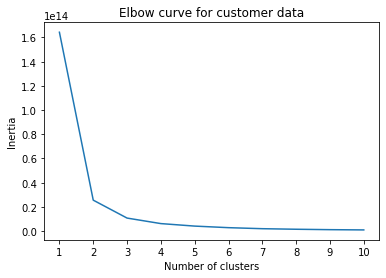

In [16]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [17]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [18]:
clusters = get_clusters(5, ml_df)

In [19]:
clusters

,ID,Avg Rating,Complexity,Category_'Abstract Strategy',Category_'Action / Dexterity',Category_'Adventure',Category_'Age of Reason',Category_'American Civil War',Category_'American Revolutionary War',Category_'American West',...,Mechanic_'Team-Based Game',Mechanic_'Tile Placement',Mechanic_'Trading',Mechanic_'Trick-taking',Mechanic_'Variable Phase Order',Mechanic_'Variable Player Powers',Mechanic_'Voting',Mechanic_'Worker Placement',Mechanic_Other,class
0,174430,8.85292,3.8078,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,161936,8.62499,2.8301,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
2,167791,8.42299,3.2313,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
3,182028,8.49419,4.3850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,224517,8.62031,3.9122,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5154,6.00000,0.0000,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19996,5158,4.00000,0.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,5159,6.00000,0.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,5160,5.77500,0.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def show_clusters(df):
    plt.scatter(df['Avg Rating'], df['Complexity'], c=df['class'])
    plt.xlabel('Avg Rating')
    plt.ylabel('Complexity')
    plt.show()

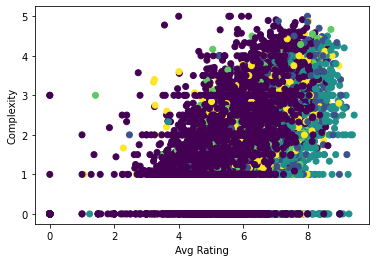

In [21]:
show_clusters(clusters)

In [22]:
y = clusters['ID']
X = clusters.drop(columns='ID')

# KNN Training

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [25]:
knn.score(X_train, y_train)

C:\Users\rcman\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.1702

In [26]:
knn.score(X_test, y_test)

C:\Users\rcman\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.0

# Keras

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [44]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# train set / data 
x_train = x_train.reshape(-1, 28*28)
x_train = x_train.astype('float32') / 255

# train set / target 
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)

11501568/11490434 [==============================] - 1s 0us/step


In [45]:
nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(800, input_dim=784, activation="relu"))

nn_model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [46]:
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


In [47]:
nn_model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

In [48]:
# fit_model = nn_model.fit(X_train_scaled, y_train, epochs=78)

fit_model = nn_model.fit(x_train, y_train, 
                    batch_size=200, 
                    epochs=20,  
                    verbose=1)

Epoch 1/20
300/300 [==============================] - 2s 5ms/step - loss: 1.2855 - accuracy: 0.7239
Epoch 2/20
300/300 [==============================] - 1s 5ms/step - loss: 0.6334 - accuracy: 0.8570
Epoch 3/20
300/300 [==============================] - 1s 5ms/step - loss: 0.4912 - accuracy: 0.8784
Epoch 4/20
300/300 [==============================] - 1s 5ms/step - loss: 0.4291 - accuracy: 0.8888
Epoch 5/20
300/300 [==============================] - 1s 5ms/step - loss: 0.3927 - accuracy: 0.8957
Epoch 6/20
300/300 [==============================] - 1s 5ms/step - loss: 0.3680 - accuracy: 0.9005
Epoch 7/20
300/300 [==============================] - 1s 5ms/step - loss: 0.3497 - accuracy: 0.9043
Epoch 8/20
300/300 [==============================] - 1s 5ms/step - loss: 0.3351 - accuracy: 0.9081
Epoch 9/20
300/300 [==============================] - 1s 5ms/step - loss: 0.3230 - accuracy: 0.9108
Epoch 10/20
300/300 [==============================] - 2s 6ms/step - loss: 0.3127 - accuracy: 0.9136

In [51]:
model_loss, model_accuracy = nn_model.evaluate(x_train,y_train,verbose=1)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2459 - accuracy: 0.9318
Loss: 0.2459496706724167, Accuracy: 0.9318166375160217


<AxesSubplot:>

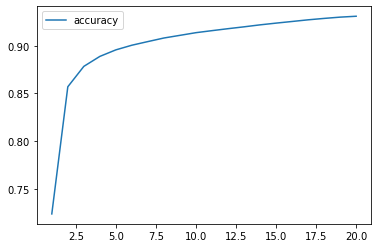

In [52]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")